# Self-Driving Car Engineer Nanodegree

## Project: Vehicle Detection

In [1]:
# import everything we need

import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import time
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import center_of_mass

In [2]:
# Read in car and non-car images for training the classifier

cars = glob.glob('training_images/vehicles/*/*.png')
notcars = glob.glob('training_images/non-vehicles/*/*.png')
print("Read {0} car images and {1} not car images.".format(len(cars),len(notcars)))

Read 8792 car images and 8968 not car images.


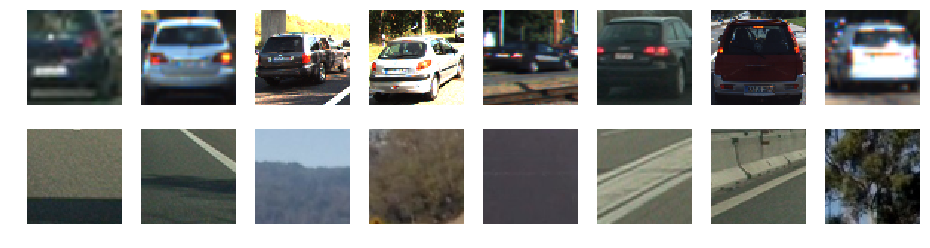

In [3]:
# visualize training images (car and not car)

fig,axes = plt.subplots(2,8,figsize=(16,4))
axes = axes.ravel()
for i in range(8):
    fn = np.random.choice(cars)
    im = mpimg.imread(fn)
    axes[i].axis('off')
    axes[i].imshow(im)
for i in range(8):
    fn = np.random.choice(notcars)
    im = mpimg.imread(fn)
    axes[i+8].axis('off')
    axes[i+8].imshow(im)
plt.show()
fig.savefig(os.path.join('output_images/training_images.png'),bbox_inches='tight')

In [4]:
# define utility functions

def convert_color(image, color_space='RGB'):
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    return feature_image
    
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


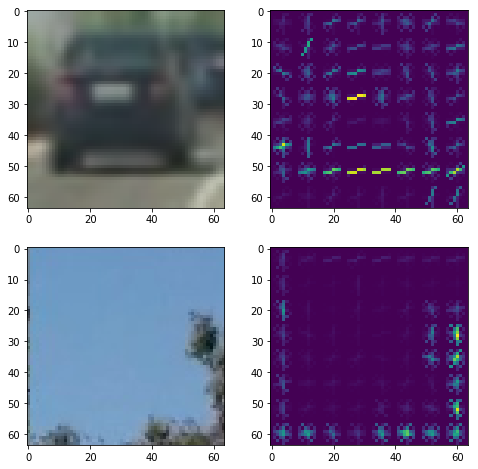

In [5]:
# visualize hog features

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))
image = mpimg.imread(cars[0])
ax1.imshow(image)
im_color = convert_color(image,'RGB')
_,hog_im = get_hog_features(im_color[:,:,0],orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
ax2.imshow(hog_im)
image = mpimg.imread(notcars[0])
ax3.imshow(image)
im_color = convert_color(image,'RGB')
_,hog_im = get_hog_features(im_color[:,:,0],orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
ax4.imshow(hog_im)
plt.show()
fig.savefig(os.path.join('output_images/hog_features.png'),bbox_inches='tight')

In [6]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(image,color_space)
        
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [7]:
# define feature extraction parameters and extract features

color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb  (YUV optimal?)
orient = 11  # HOG orientations (11 optimal?)
pix_per_cell = 16 # HOG pixels per cell (16 optimal?)
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (8, 8) # Spatial binning dimensions
hist_bins = 64    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 656] # Min and max in y to search in slide_window()

t1 = time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
t2 = time.time()
print(round(t2-t1, 2), 'Seconds to extract features...')

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


114.13 Seconds to extract features...
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1572


In [8]:
# Train a linear SVC 

svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

2.91 Seconds to train SVC...
Test Accuracy of SVC =  0.989


In [9]:
# define utility functions for sliding windows

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    # Compute the span of the region to be searched    
    # Compute the number of pixels per step in x/y
    # Compute the number of windows in x/y
    
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    x_span = x_start_stop[1] - x_start_stop[0]
    y_span = y_start_stop[1] - y_start_stop[0]
    n_pixels_x = np.int(xy_window[0] * (1-xy_overlap[0]))
    n_pixels_y = np.int(xy_window[1] * (1-xy_overlap[1]))
    x_buffer = n_pixels_x * xy_overlap[0]
    y_buffer = n_pixels_y * xy_overlap[1]
    n_windows_x = np.int( (x_span - x_buffer) / n_pixels_x )
    n_windows_y = np.int( (y_span - y_buffer) / n_pixels_y )
    
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
        # Calculate each window position
        # Append window position to list
        
    for xs in range(n_windows_x):
        for ys in range(n_windows_y):
            #x1,y1 = xs * n_pixels_x, ys * n_pixels_y
            x1,y1 = xs * n_pixels_x + x_start_stop[0], ys * n_pixels_y + y_start_stop[0]
            x2,y2 = x1 + xy_window[0], y1 + xy_window[1]
            window_list.append( ( (x1,y1),(x2,y2) ) )
        
    # Return the list of windows
    return window_list

In [10]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    feature_image = convert_color(img,color_space)    
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

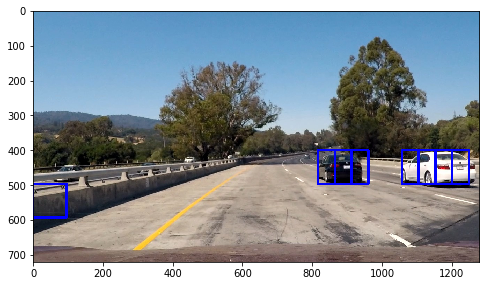

In [11]:
# demonstrate window search

image = mpimg.imread('test_images/test1.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,656], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

fig = plt.figure(figsize=(8,6))
plt.imshow(window_img)
plt.show()
fig.savefig(os.path.join('output_images/sliding_window_detection.png'),bbox_inches='tight')

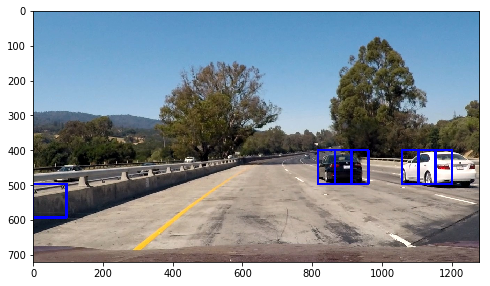

In [12]:
# define pipeline to search for cars at different scales; use accelerated hog feature extraction

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    hot_boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                hot_boxes.append( ((xbox_left,ytop+ystart),(xbox_left+win_draw,ytop+ystart+win_draw)) )
                
    return draw_img, hot_boxes
    
ystart = 400
ystop = 656
scale = 1.5
   
img = mpimg.imread('test_images/test1.jpg')
out_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
fig = plt.figure(figsize=(8,6))
plt.imshow(out_img)
plt.show()
fig.savefig(os.path.join('output_images/sliding_window_detection_scaled.png'),bbox_inches='tight')

In [13]:
# define utility functions for heat map

def add_heat(heatmap, bbox_list, strength=1.0):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += strength

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels, color=(0,0,255), thickness=6):
    # Iterate through all detected cars
    car_boxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], color, thickness)
        car_boxes.append(bbox)
    # Return the image
    return img, car_boxes


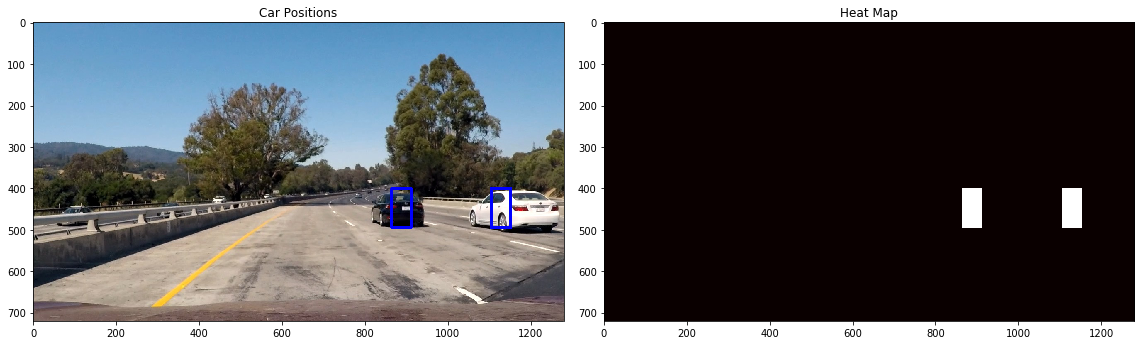

In [14]:
# demonstrate heat map

ystart = 400
ystop = 656
scale = 1.5
   
img = mpimg.imread('test_images/test1.jpg')
out_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

# Add heat to each box in box list
heat = np.zeros_like(img[:,:,0]).astype(np.float)
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img, detected_cars = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

plt.show()
fig.savefig(os.path.join('output_images/heat_map.png'),bbox_inches='tight')

In [15]:
# define class to hold previous detections

class vehicleDetections(object):
    
    def __init__(self,memory,frame_decay=0.8,heat_threshold=1):
        self.memory = memory
        self.boxes = []
        self.frame_decay = frame_decay
        self.heat_threshold = heat_threshold
        self.tracking_boxes = []
                    
    def add_boxes(self,boxes):
        # track bboxes of detections from heat map
        
        if len(boxes):
            self.boxes.insert(0,boxes)
        if len(self.boxes) > self.memory:
            self.boxes = self.boxes[0:self.memory]
            
    def update_tracking(self,labels):
        # track bboxes of detections from labeling procedure
    
        label_array,num_labels = labels
        new_boxes = []
        for car_number in range(1, num_labels+1):
        # Find pixels with each car_number label value
            nonzero = (label_array == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            new_box = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            new_boxes.append(new_box)
            
        def weighted_add(pt1,pt2,weight):
            new_x = int( weight * pt1[0] + (1-weight) * pt2[0] )
            new_y = int( weight * pt1[1] + (1-weight) * pt2[1] )
            return (new_x,new_y)
            
        m = float(1/self.memory)
                
        if len(new_boxes) == len(self.tracking_boxes):
            # same number of cars as last frame
            for i in range(num_labels):         
                pt1 = weighted_add(new_boxes[i][0],self.tracking_boxes[i][0],m)
                pt2 = weighted_add(new_boxes[i][1],self.tracking_boxes[i][1],m)
                self.tracking_boxes[i] = (pt1,pt2)
          
        else:
            # different number of cars as last frame
            # probably should add better persistence here
            self.tracking_boxes = new_boxes
            
        return self.tracking_boxes
    

In [16]:
# process image

def process_image(img):
    
    scales = [  {'scale':0.75, 'yrange':[400,496]},
                {'scale':1.0, 'yrange':[400,464]},
                {'scale':1.0, 'yrange':[416,480]},
                {'scale':1.5, 'yrange':[400,496]},
                {'scale':1.5, 'yrange':[432,528]},
                {'scale':2.0, 'yrange':[400,656]},
                {'scale':3.0, 'yrange':[400,656]},
             ]
    
    car_boxes = []
    for scale_set in scales:
        scale = scale_set['scale']
        ystart,ystop = scale_set['yrange']
        out_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, 
                                      orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

        # accumulate detection boxes from each scale
        car_boxes.extend(box_list)
                
    # add all detections to tracking list
    detection_history.add_boxes(car_boxes)
    
    # use memory of all detections in past frames (up to memory) to build heat map
    # weight most recent frames strongest
    heat = np.zeros_like(img[:,:,0]).astype(np.float)    
    for i,old_boxes in enumerate(detection_history.boxes):
        heat = add_heat(heat,old_boxes,strength=(detection_history.frame_decay)**i)
        
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,detection_history.heat_threshold)

    # Find boxes from heatmap using label function
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    
    # add labeled box boundaries to tracking list and get rolling average
    boxes_to_draw = detection_history.update_tracking(labels)
    draw_img = draw_boxes(np.copy(img),boxes_to_draw)
            
    # write label of how many cars we're tracking
    box_string = "Cars tracked: {0}".format(labels[1])
    cv2.putText(draw_img,box_string,(100,90),cv2.FONT_HERSHEY_SIMPLEX,1.5,(255,255,255),thickness=2)
        
    return draw_img
    

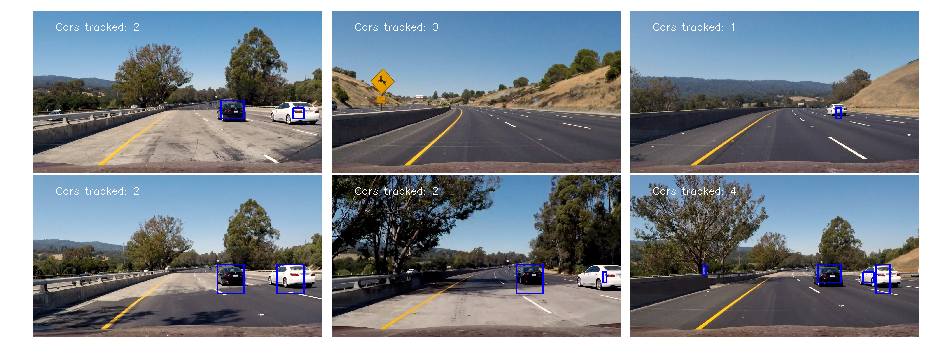

In [17]:
# demonstrate pipeline on all test images

detection_history = vehicleDetections(memory=1)
test_images = glob.glob('test_images/*.jpg')
fig,ax = plt.subplots(2,3,figsize=(16,6))
fig.subplots_adjust(hspace = 0.01, wspace=0.01)
axes = ax.ravel()
for i,fn in enumerate(test_images):
    im = mpimg.imread(fn)
    im_cars = process_image(im)
    axes[i].imshow(im_cars)
    axes[i].axis('off')
plt.show()
fig.savefig(os.path.join('output_images/full_pipeline.png'),bbox_inches='tight')

In [18]:
# process video

detection_history = vehicleDetections(memory=8,frame_decay=0.8,heat_threshold=4)
video_output = 'output_video/video_output.mp4'
#clip = VideoFileClip('./test_video.mp4')
clip = VideoFileClip('./project_video.mp4').subclip(10,50)
clip_out = clip.fl_image(process_image)
clip_out.write_videofile(video_output, audio=False)


[MoviePy] >>>> Building video output_video/video_output.mp4
[MoviePy] Writing video output_video/video_output.mp4


100%|█████████▉| 1000/1001 [08:00<00:00,  2.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/video_output.mp4 

